# Benchmark Pan 2014 para esse problema

resultados com micro-avg < 0.30  foram removidos

|Team                  |Dutch    |English    |Greek     |Spanish     |Micro-avg|Macro-avg|
|----------------------|--------:|----------:|---------:|-----------:|--------:|--------:|
|Bagnall               |0.451    |**0.614**  |**0.750** |**0.721**   |0.608    |0.628    |
|Bartoli et al.        |0.518    |0.323      |0.458     |0.773       |0.417    |0.506    |
|Castro-Castro et al.  |0.247    |**0.520**  |0.391     |0.329       |0.427    |0.365    |
|Gómez-Adorno et al.   |0.390    |0.281      |0.348     |0.281       |0.308    |0.323    |
|Gutierrez et al.      |0.329    |0.513      |0.581     |0.509       |0.479    |0.478    |
|Halvani               |0.455    |0.458      |0.493     |0.441       |0.445    |0.462    |
|Hürlimann et al.      |0.616    |0.412      |0.599     |0.539       |0.487    |0.538    |
|Kocher & Savoy        |0.218    |0.508      |0.631     |0.366       |0.435    |0.416    |
|Maitra et al.         |0.518    |0.347      |0.357     |0.352       |0.378    |0.391    |
|Moreau et al.         |**0.635**|0.453      |**0.693** |0.661       |0.534    |0.606    |
|Pacheco et al.        |0.624    |0.438      |0.517     |0.663       |0.480    |0.558    |
|PAN15-ENSEMBLE        |0.426    |0.468      |0.537     |0.715       |0.475    |0.532    |
|PAN14-BASELINE-1      |0.255    |0.249      |0.198     |0.443       |0.269    |0.280    |
|PAN14-BASELINE-2      |0.191    |0.409      |0.412     |0.683       |0.406    |0.405    |
|PAN13-BASELINE        |0.242    |0.404      |0.384     |0.367       |0.358    |0.347    |

## Bibliotecas

In [1]:
%matplotlib inline
#bibliotecas padrões do python
import os;
import codecs;
import re;
import math;
import pickle;
from __future__ import print_function;

#bibliotecas científicas
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import random;


#bibliotecas para machine learning
from sklearn.pipeline import Pipeline;
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer;

from sklearn.metrics.pairwise  import cosine_similarity, paired_distances;
from sklearn.preprocessing     import RobustScaler, MaxAbsScaler, MinMaxScaler, normalize;
from sklearn.decomposition     import PCA;
from sklearn.feature_selection import SelectPercentile,SelectFpr, f_classif, chi2;
from sklearn.model_selection   import StratifiedKFold,  GridSearchCV;
from sklearn.pipeline          import Pipeline;
from sklearn.metrics           import f1_score, pairwise_distances, precision_recall_fscore_support, roc_auc_score;

from sklearn.linear_model      import LogisticRegression;
from sklearn.metrics           import classification_report, roc_curve;


import seaborn as sns;

#import statsmodels.discrete.discrete_model as sm;

#bibliotecas customizadas.
from toolboxAnalytics import  rocKS, rocCurve, ksCurve;
from IPython.core.display import display, HTML, Markdown;

np.set_printoptions(precision=3);

## Leitura dos datasets por tipo

In [ ]:
def readFiles(path, problemID):
    #lendo os textos do autor conhecido
    known = "";
    for i in xrange(5):
        fname = os.path.join(path,"known0"+str(i)+".txt");
        if os.path.exists(fname):
            with codecs.open(fname) as f:
                known += f.read();
                
    #lendo o texto desconhecido
    with codecs.open(os.path.join(path,"unknown.txt")) as f:
        unknown = f.read();
        
    return (problemID, known, unknown);

#reading all folders /instances of the problem

#método para ler uma instancia e transformar em dataframe
def readInstanceAsDataFrame(task, corpus):
    print ("reading the task %s - %s " % (task, corpus));
    
    #cada task contem uma pasta para cada instancia de problema. 
    #ler todas as pastas e transformar uma tupla /dataframe
    path = os.path.join(r'.\trainingData', 'pan14-author-verification-'+corpus+'-'+task+'-2014-04-22')
    problems = [readFiles(os.path.join(path,problemID),problemID)
                    for problemID in os.listdir(path)
                            if os.path.isdir(os.path.join(path,problemID))
               ];
    problemID, known, unknown = zip(*problems);
    dfData = pd.DataFrame({'problemID':problemID,'known':known, 'unknown':unknown});
    
    #lendo o arquivo texto com o ground truth
    dfProblem = pd.read_table(
                    os.path.join(path,"truth.txt"),
                    sep=' ',
                    header=None,
                    names=['problemID','truth']
                );
    
    
    #criando um dataset unico;
    dataset = pd.merge(dfData, dfProblem, on='problemID');
    dataset['genre'] = task.split('-')[1];
    dataset['task'    ] = task;
    dataset['language'] = task.split("-")[0];
    dataset['corpus'  ] = corpus;
    return dataset[['corpus','problemID','language','genre','task', 'known','unknown','truth']];

In [ ]:
tasks = ['dutch-essays', 'dutch-reviews','english-essays','english-novels', 'greek-articles', 'spanish-articles'];
corpus = ['training-corpus','test-corpus1','test-corpus2']
dataset = [
        readInstanceAsDataFrame(t, c)
            for t in tasks
                for c in corpus
        ]
dataset = pd.concat(dataset);

dataset.head()

In [ ]:
display(HTML("<span style='color:red'> Salvando banco de dados consolidado </span>"));
with codecs.open("PAN2014consolidado.json",'w') as f:
    f.write(dataset.reset_index().to_json());

# Partindo dos dados consolidados previamente

In [2]:
display(HTML("<span style='color:red'> Lendo banco de dados consolidado </span>"));
with codecs.open("PAN2014consolidado.json",'r') as f:
    dataset = pd.read_json(f.read())

### Filtrando apenas espanhol e inglês e base de treinamento

In [3]:
dataset = dataset[((dataset.language != 'dutch') & (dataset.language != 'greek') & (dataset.corpus == 'training-corpus'))];
dataset.drop('corpus',axis=1, inplace=True);

In [4]:
dataset.head()

,genre,index,known,language,problemID,task,truth,unknown
1000,novels,10,IV. A Mutation and a Madness\n\n1.\n\nIn the w...,english,EN011,english-novels,Y,III.\n\nMeanwhile Old Whateley continued to bu...
1001,novels,11,"﻿Spoonbill Village, Northernmost Quang Binh Pr...",english,EN012,english-novels,Y,"﻿May 19th, 1929,\nMiskatonic University, Arkha..."
1002,novels,12,III. A Search and an Evocation\n\n1.\n\nCharle...,english,EN013,english-novels,Y,"“Gorgons, and Hydras, and Chimaeras—dire stori..."
1003,novels,13,﻿Day 1-I never would imagine such thing would ...,english,EN014,english-novels,N,V.\n\nThe following winter brought an event no...
1004,novels,14,"""The essential Saltes of Animals may be so pre...",english,EN015,english-novels,N,"﻿Ordinarily, one wouldn't think of the Dreamer..."


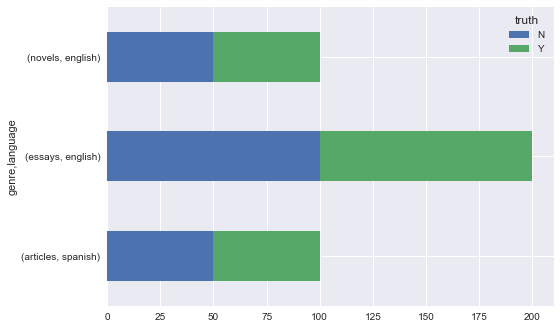

In [5]:
dataset\
.pivot_table(values='problemID',index=['genre','language'],columns='truth',aggfunc='count') \
.plot.barh(stacked=True);

# Funções utilitárias

In [6]:
def histograma(title, var, truth):
    """
    Essa função desenha 2 histogramas sobrepostos. 1 com a classe positiva e outro a classe negativa.
    Isso permite verificar visualmente o poder de separação da variável com relação as classes.
    
    Ps.:  O poder total de separação deve ser verificado pela função
    ksCurve que plota a curva acumulada e o poder de separação todal.
    """
    plt.title(title)
    plt.hist(var[truth == 'N'], label=u"outro autor", bins=30, color='#CC2222', alpha=0.5);
    plt.hist(var[truth == 'Y'], label=u"mesmo autor", bins=30, alpha=0.5);
    plt.xlabel(u"Distância");
    plt.legend(loc='upper right')

In [7]:
def histograma2(title, var, truth):
    """
    Essa função desenha 2 histogramas sobrepostos. 1 com a classe positiva e outro a classe negativa.
    Isso permite verificar visualmente o poder de separação da variável com relação as classes.
    
    Ps.:  O poder total de separação deve ser verificado pela função
    ksCurve que plota a curva acumulada e o poder de separação todal.
    """
    plt.title(title)
    plt.hist(var[truth], label=u"FALSE CLASS", bins=30, color='#CC2222', alpha=0.5);
    plt.hist(var[truth], label=u"TRUE CLASS", bins=30, alpha=0.5);
    plt.xlabel(u"Distância");
    plt.legend(loc='upper right')

In [8]:
def pcaCutOff(pca, cutVariance =0.95, plot=False):
    """Esse método calcula quantas componentes são necessário para explicar  o percentual de variancia desejada."""
    variance = pca.explained_variance_ratio_.cumsum();
    cutoff = len(variance[variance< cutVariance]);
    
    if plot:
        plt.figure(1, figsize=(10,5))
        plt.clf()
        plt.axes([.2, .2, .7, .7])
        plt.plot(variance, linewidth=2)
        plt.axvline(x=cutoff)
        plt.axis('tight')
        plt.xlabel('n_components')
        plt.ylabel('explained_variance_')
    return cutoff;

In [9]:
def cosine(matrixA, matrixB):
    """Essa função calcula a similaridade de cossenos entre duas matrizes e retorna um vetor que representa
    cosine[i] =  cosine(matrixA[i,:], matrixB[i,:])
    como preprocessamento, a matrizes passam por um normalização L2 para evitar que a norma influencie
    """
    return np.array(np.diag(
        cosine_similarity(
            normalize(matrixA, norm='l2'),
            normalize(matrixB, norm='l2')
        )
    )).flatten();

In [10]:
def pcaSimilarity(pca, matrixA, matrixB):
    """calcula a similaridade considerando apenas algumas componentes da PCA"""
    pcaknownCount   = pca.transform(matrixA);
    pcaunknownCount = pca.transform(matrixB);    
    cpca = cosine(pcaknownCount,pcaunknownCount);
    return cpca;

In [11]:
def CNG_Keselj(matrixA, matrixB):
    """
    A profile-based method of particular interest, the Common n-Grams (CNG) approach, was described by Keselj, et al. (2003).
    -1 vetor A tem valores maiores
    0  A e B são iguais
    1  vetor B  tem valores maiores
    """
    matrixA = normalize(matrixA, norm='l1')
    matrixB = normalize(matrixB, norm='l1')
    dif   = (matrixA) - (matrixB);
    summ   = (matrixA) + (matrixB);
    
    s = (2 * dif /summ) **2;
    s = np.array(np.nansum(s, axis=1)).flatten();    
    return s;

In [12]:
def CNG_Statamatos(matrixA, matrixB):
    matrixA = normalize(matrixA, norm='l1')
    matrixB = normalize(matrixB, norm='l1')
    
    #difference to local
    s1 = (2 * (matrixA - matrixB) /(matrixA + matrixB)) **2;
    
    
    #global difference
    matrixCorpus = np.vstack((matrixA,matrixB));
    matrixCorpus =  normalize(np.sum(matrixCorpus,axis=0, keepdims=True), norm='l1');   
    s2 = (2 * (matrixA - matrixCorpus) /(matrixA + matrixCorpus)) **2;
    
    s = s1 * s2;    
    s = np.array(np.nansum(s, axis=1)).flatten();    
    return s;

In [13]:
def cScore( Ypred, Y):
    """função definida segundo a competição pan.  A ideia é penalisar o classificador
    que retorna probabilidade de 50%, ou seja, não ser melhor que um chute aleatório """
    Ypred = np.round(Ypred,decimals=2);
    n  = len(Y)*1.0;
    nunansweard  = np.sum(Ypred == 0.5);
    
    ncorrect = np.sum( (Ypred>0.5) & (Y == 1) ) + np.sum( (Ypred<0.5) & (Y == 0) )    
    #ncorrect = np.sum(((Ypred>0.5) == Y)) - nunansweard;    
    return (1.0/n)*(ncorrect+(nunansweard*ncorrect/n));

In [14]:
def dist(ma, mb):
    return normalize(np.array(np.abs(ma - mb)),norm='l1');
    #return np.array(np.abs(ma - mb));
    
def difchi2(ma, mb):
    return np.log(1+(np.array(ma) - np.array(mb))**2 /(1+ np.array(ma)));


def kpi(pred, y):
    ks      = ksCurve(pred,y);
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    final   = roc * c_score;
    return ks, roc, c_score, final;


def kpi2(pred, y):
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    metrics =  {
        'ks':ksCurve(pred,y),
        'auc':roc,
        'C_score': c_score,
        'f1': f1_score(y, pred),
        'PAN' : roc * c_score
        
    };
    return metrics;

## Filtrando as instancias de problemas que serão tratadas

Foi utilizado apenas o corpus de trainamento porque os corpus de teste estariam disponíveis apenas para o avaliadores.

In [15]:
datasetEstudo = dataset[ dataset['language'] == 'spanish'  ];
datasetEstudo = datasetEstudo[['problemID','language','genre','known','unknown','truth']];
datasetEstudo.head()

,problemID,language,genre,known,unknown,truth
1640,SP001,spanish,articles,﻿Antoni Puigverd escribía el lunes en La Vangu...,﻿Todo el mundo se cree en el derecho a critica...,N
1641,SP002,spanish,articles,﻿Me formulo desde hace unos días la pregunta q...,﻿El autor defiende la necesidad de modificar l...,Y
1642,SP003,spanish,articles,﻿Andamos estos días los constitucionalistas mu...,﻿El próximo día 6 se cumplirán 35 años del día...,N
1643,SP004,spanish,articles,"﻿No me gusta Amaiur, una coalición controlada ...",﻿La comparecencia del presidente del Gobierno ...,Y
1644,SP005,spanish,articles,"﻿En este periodo de replanteamiento, cuando ha...","﻿En la cresta de la ola de popularidad, el arq...",N


# Análise exploratória da base

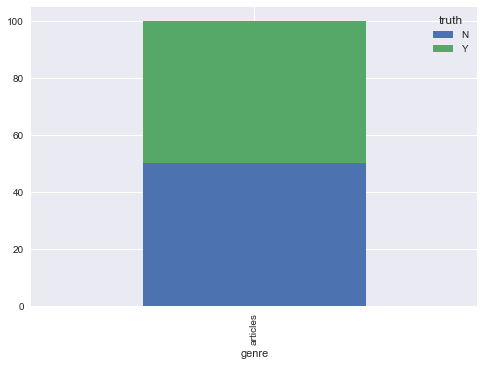

In [16]:
datasetEstudo.pivot_table(
    values='problemID',
    index=['genre'],
    columns='truth',aggfunc='count').plot.bar(stacked=True);

# analisando char n-grams  mais frequentes
Segundo a literatura (survery do stamatatos) o termos mais frequentes permitem diferenciar o autor sem ser impactados pelo contexto.
Estudando apontam também que entre 2 e 5 char n-grams apresentaram os melhores resultados.
Utilizando o TfidfVectorizer  sem a componente IDF porque ela faz pouco efeito e para utilizar a versão com 1+log(TF)

In [17]:
counter = CountVectorizer(
        analyzer="char",
        min_df=0.90,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float32
    );

In [18]:
counter.fit(datasetEstudo.known.values);
ma = counter.transform(datasetEstudo.known.values).todense();
mb = counter.transform(datasetEstudo.unknown.values).todense();

In [19]:
def normalizer(m):
    #TF
    m = normalize(m,norm='l1');
    return m;    

In [20]:
known = normalizer(ma);
unknown = normalizer(mb);

In [21]:
print ("cosine");
cosineAB = cosine(known,unknown);

print ("Cosine PCA");
pca = PCA();
pca.fit(np.vstack((known,unknown)));

variance = pca.explained_variance_ratio_.cumsum();
cutoff = len(variance[variance<=0.95]);
if cutoff < 1:
    cutoff = int(known.shape[1] *0.5);

pca = PCA(cutoff);
pca.fit(np.vstack((known,unknown)));
del variance;
cosineABpca = pcaSimilarity(pca,known,unknown);

print ("CNG_Keselj");
keselj = CNG_Keselj(known,unknown);

print ("CNG_Statamatos");
statamatos =CNG_Statamatos(known,unknown);


print ("correlation");
correlation = np.diag(pairwise_distances(known, unknown, metric='correlation'))
jaccard = np.diag(pairwise_distances(known > 0, unknown >0, metric='jaccard'))

cosine
Cosine PCA
CNG_Keselj
CNG_Statamatos
correlation


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


# analise descritiva das variáveis criadas

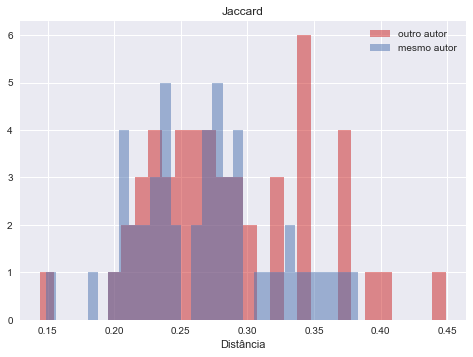

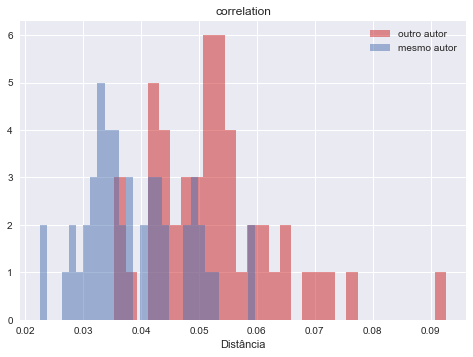

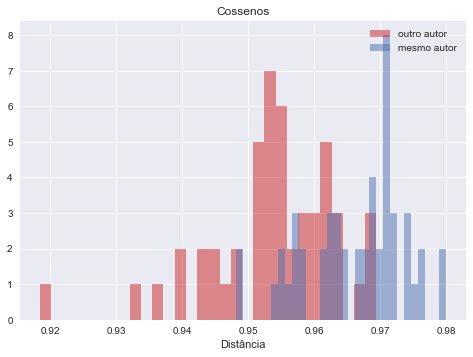

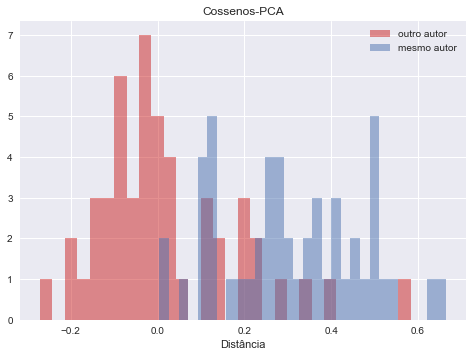

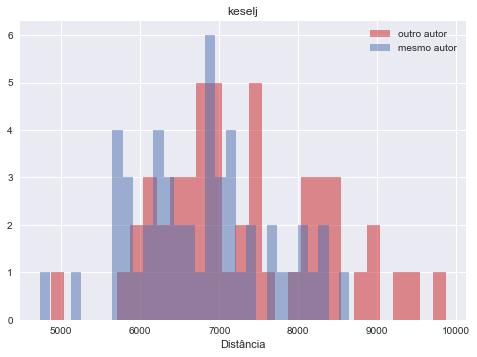

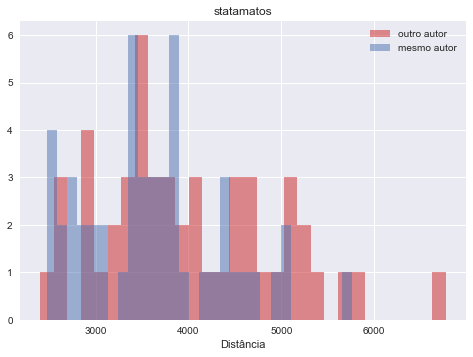

In [22]:
pcaCutOff(pca);plt.show();
histograma('Jaccard',jaccard, datasetEstudo.truth.values); plt.show();
histograma('correlation',correlation, datasetEstudo.truth.values); plt.show();
histograma('Cossenos',cosineAB, datasetEstudo.truth.values); plt.show();
histograma('Cossenos-PCA',cosineABpca, datasetEstudo.truth.values) ;plt.show();
histograma('keselj',keselj, datasetEstudo.truth.values) ;plt.show();
histograma('statamatos',statamatos, datasetEstudo.truth.values) ;plt.show();

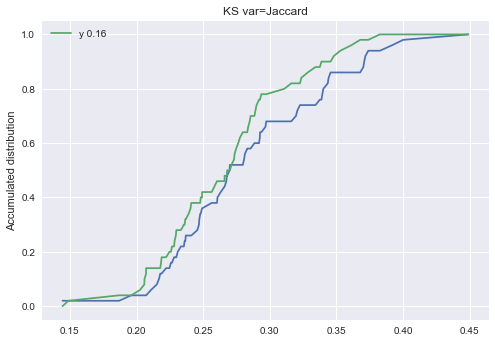

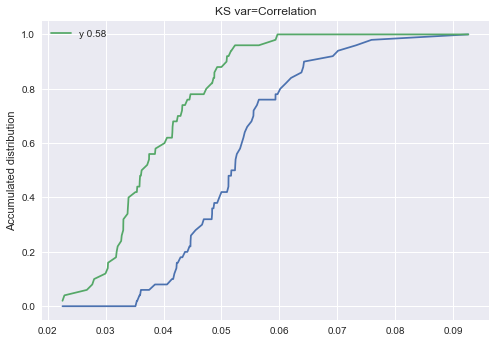

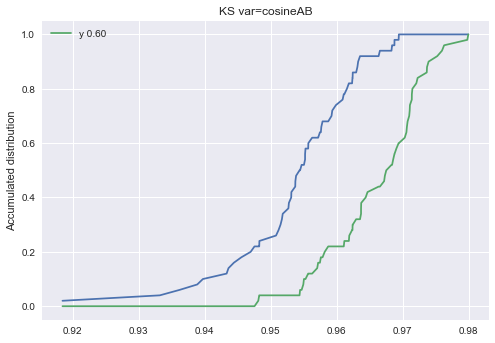

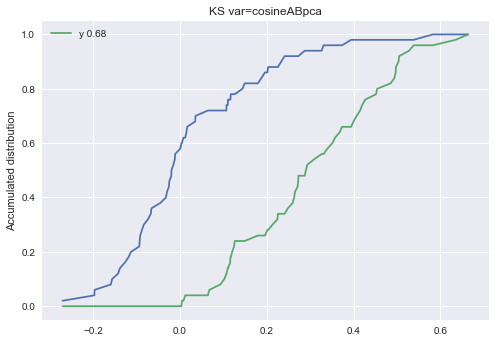

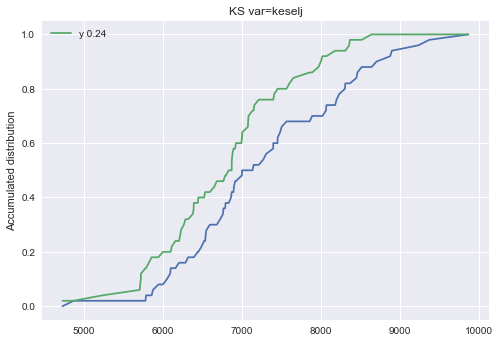

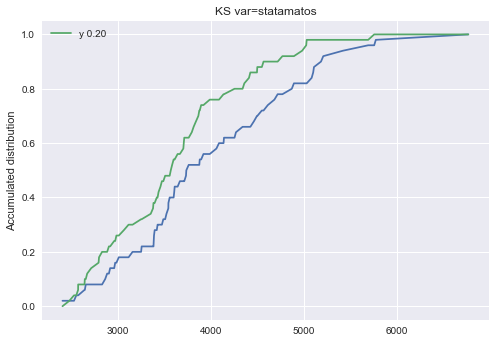

In [23]:
pcaCutOff(pca);plt.show();
plt.title("KS var=Jaccard")   ;ksCurve(jaccard, datasetEstudo.truth.values=="Y", plot=True); plt.show();
plt.title("KS var=Correlation")   ;ksCurve(correlation, datasetEstudo.truth.values=="Y", plot=True); plt.show();
plt.title("KS var=cosineAB")   ;ksCurve(cosineAB, datasetEstudo.truth.values=="Y", plot=True); plt.show();
plt.title("KS var=cosineABpca");ksCurve(cosineABpca, datasetEstudo.truth.values=="Y", plot=True) ;plt.show();
plt.title("KS var=keselj")         ;ksCurve(keselj, datasetEstudo.truth.values=="Y", plot=True) ;plt.show();
plt.title("KS var=statamatos");ksCurve(np.abs(statamatos), datasetEstudo.truth.values=="Y", plot=True) ;plt.show();

In [24]:
Y = datasetEstudo.truth.values=="Y";
KS = pd.DataFrame(
    {'Dissimilaridade':['Jaccard','CNG-keselj','CNG-Statamatos', 'Correlation','Cosseno','Cosseno-PCA'],
      'Kolmogorov-Smirnov': [
          ksCurve(jaccard, Y),
          ksCurve(keselj, Y),
          ksCurve(statamatos, Y),
          ksCurve(correlation, Y),
          ksCurve(cosineAB, Y),
          ksCurve(cosineABpca, Y),

      ],
    'fClassifDF': [
          (f_classif(jaccard.reshape(-1, 1), Y)[1])[0],
          (f_classif(keselj.reshape(-1, 1), Y)[1])[0],
          (f_classif(statamatos.reshape(-1, 1), Y)[1])[0],
          (f_classif(correlation.reshape(-1, 1), Y)[1])[0],
          (f_classif(cosineAB.reshape(-1, 1), Y)[1])[0],
          (f_classif(cosineABpca.reshape(-1, 1), Y)[1])[0],

      ] 
    }
);
#KS.plot(kind='bar',x='Dissimilaridade', y='Kolmogorov-Smirnov');
pd.set_option('precision',7)
KS.to_clipboard(excel=True);
KS


,Dissimilaridade,Kolmogorov-Smirnov,fClassifDF
0,Jaccard,0.16,1.4300820e-01
1,CNG-keselj,0.24,9.5953578e-03
2,CNG-Statamatos,0.20,3.0430950e-02
3,Correlation,0.58,1.4122570e-10
4,Cosseno,0.60,1.1714688e-10
5,Cosseno-PCA,0.68,5.7747451e-14


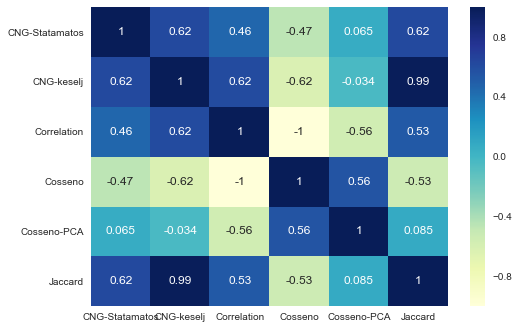

In [25]:
Attr = pd.DataFrame(
    {'Jaccard':jaccard,
     'CNG-keselj':keselj,
     'CNG-Statamatos':statamatos,
     'Correlation':correlation,
     'Cosseno':cosineAB,
     'Cosseno-PCA':cosineABpca,
    }
);
Attr
corr = Attr.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

In [26]:
corr

,CNG-Statamatos,CNG-keselj,Correlation,Cosseno,Cosseno-PCA,Jaccard
CNG-Statamatos,1.0000000,0.6179333,0.4584855,-0.4654937,0.0650845,0.6187613
CNG-keselj,0.6179333,1.0000000,0.6151339,-0.6210460,-0.0343278,0.9866300
Correlation,0.4584855,0.6151339,1.0000000,-0.9997201,-0.5614720,0.5252132
Cosseno,-0.4654937,-0.6210460,-0.9997201,1.0000000,0.5572099,-0.5315060
Cosseno-PCA,0.0650845,-0.0343278,-0.5614720,0.5572099,1.0000000,0.0845873
Jaccard,0.6187613,0.9866300,0.5252132,-0.5315060,0.0845873,1.0000000


In [ ]:
corr.to_clipboard(excel=True)

In [ ]:
del ma, mb, corr, KS, jaccard, keselj, statamatos, correlation, cosineAB, cosineABpca, known, unknown;

# Classificador utilizando as funções de similiaridade

In [27]:
XK = datasetEstudo.known.values;
XU = datasetEstudo.unknown.values;
Y = datasetEstudo.truth.values=="Y";

In [28]:
kf = StratifiedKFold(n_splits=5, random_state =0);

counter = CountVectorizer(
        analyzer="char",
        min_df=0.90,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float32
    );

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('clf', LogisticRegression(random_state = 0)) 
]);

pipeline2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(random_state = 0)) 
]);

In [29]:
modelsResults = [];

i =0;

for train_index, test_index in kf.split(XK, Y):
    i=i+1;
    print("\niniciando iteração %d" % i);
    
    XKtrain, XKtest = XK[train_index], XK[test_index];
    XUtrain, XUtest = XU[train_index], XU[test_index];
    YTrain , YTest  = Y[train_index] , Y[test_index];
    
    print("counter");
    counter.fit(np.append(XKtrain,XUtrain));
    XKtrain, XKtest = counter.transform(XKtrain).todense(), counter.transform(XKtest).todense();
    XUtrain, XUtest = counter.transform(XUtrain).todense(), counter.transform(XUtest).todense();
    
    XKtrain, XKtest  = normalizer(XKtrain), normalizer(XKtest);
    XUtrain, XUtest  = normalizer(XUtrain), normalizer(XUtest);    
    
    
    print("X training");  
    pca = PCA();
    pca.fit(np.vstack((XKtrain,XUtrain)));
    variance = pca.explained_variance_ratio_.cumsum();
    cutoff = len(variance[variance<=0.95]);
    if cutoff < 1:
        cutoff = int(XKtrain.shape[1] *0.9);

    pca = PCA(cutoff);    
    pca.fit(np.vstack((XKtrain,XUtrain)));
    
    cosineABtrain    = cosine(XKtrain,XUtrain);
    cosineABpcatrain = pcaSimilarity(pca,XKtrain,XUtrain);    
    Statamatostrain  = CNG_Statamatos(XKtrain, XUtrain);
    keseljtrain      = CNG_Keselj(XKtrain, XUtrain);
    jaccardtrain     = np.diag(pairwise_distances(XKtrain > 0, XUtrain >0, metric='jaccard'));
    
    Xtrain = np.vstack((cosineABtrain, cosineABpcatrain , Statamatostrain, keseljtrain, jaccardtrain)).T;
    
    print("X test");
    cosineABtest     = cosine(XKtest,XUtest);
    cosineABpcatest  = pcaSimilarity(pca,XKtest,XUtest);    
    Statamatostest   = CNG_Statamatos(XKtest, XUtest);
    keseljtest       = CNG_Keselj(XKtest, XUtest);
    jaccardtest      = np.diag(pairwise_distances(XKtest > 0, XUtest >0, metric='jaccard'));
    
    Xtest = np.vstack((cosineABtest, cosineABpcatest , Statamatostest, keseljtest, jaccardtest)).T;
    
    modesl = ['cosineAB', 'cosinePCA', 'Stamatatos','keselj','jaccard'];
    for j in range(Xtrain.shape[1]):
            print("modelo  vars");
            pipeline2.fit(Xtrain[:,j].reshape(-1,1),YTrain);
            predTrain = pipeline2.predict_proba(Xtrain[:,j].reshape(-1,1));
            predTest = pipeline2.predict_proba(Xtest[:,j].reshape(-1,1));

            modelsResults.append({        
                'kfold'     : i,
                'model'     :modesl[j],
                'train': roc_auc_score(YTrain, predTrain[:,1]),
                'test' : roc_auc_score(YTest, predTest[:,1])
            })  ;
    
    print("modelo  mix");
    Xtrain = np.vstack((cosineABtrain, cosineABpcatrain , Statamatostrain)).T;
    Xtest  = np.vstack((cosineABtest, cosineABpcatest , Statamatostest)).T;
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'mix',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1])
    })  ;
    
    print("modelo CNG distancia 1");
    Xtrain = dist(XKtrain,XUtrain);
    Xtest = dist(XKtest,XUtest);
    
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'distancia 1',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1])
    });
    
    print("modelo CNG distancia 2");
    Xtrain = difchi2(XKtrain,XUtrain);
    Xtest = difchi2(XKtest,XUtest);
    
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'distancia 2',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1])
    });


iniciando iteração 1
counter
X training
X test
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]



iniciando iteração 2
counter
X training
X test
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 3
counter
X training
X test
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 4
counter
X training
X test
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2

iniciando iteração 5
counter
X training
X test
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  vars
modelo  mix
modelo CNG distancia 1
modelo CNG distancia 2


In [32]:
df = pd.DataFrame(modelsResults).groupby(by=['model']).mean();
df.to_clipboard(excel=True);
pd.DataFrame(modelsResults).groupby(by=['model']).mean()

,kfold,test,train
model,,,
Stamatatos,3,0.588,0.579250
cosineAB,3,0.884,0.863875
cosinePCA,3,0.922,0.896875
distancia 1,3,0.470,1.000000
distancia 2,3,0.718,1.000000
jaccard,3,0.567,0.545250
keselj,3,0.712,0.661125
mix,3,0.930,0.925250


In [31]:
df = pd.DataFrame(modelsResults);
#df.sort_values(['model','kfold'], inplace=True);

df

,kfold,model,test,train
0,1,cosineAB,0.790,0.8843750
1,1,cosinePCA,0.810,0.9312500
2,1,Stamatatos,0.610,0.5831250
3,1,keselj,0.680,0.6737500
4,1,jaccard,0.580,0.5387500
5,1,mix,0.810,0.9493750
6,1,distancia 1,0.480,1.0000000
7,1,distancia 2,0.760,1.0000000
8,2,cosineAB,0.970,0.8443750
9,2,cosinePCA,0.860,0.9056250
